In [4]:
import pandas as pd

# Load peace agreement and termination datasets
peace_df = pd.read_excel("ucdp-peace-agreements-221.xlsx", sheet_name="Dataset")
term_df = pd.read_excel("ucdp-term-dyad-3-2021.xlsx", sheet_name="dataset")

# Inspect column names
print("\nPeace Agreement Columns:\n", peace_df.columns.tolist())
print("\nTermination Dataset Columns:\n", term_df.columns.tolist())

# Show first few rows for review
print("\nSample rows from peace_df:\n", peace_df.head(3))
print("\nSample rows from term_df:\n", term_df.head(3))

# Clean key columns
peace_df['peace_date'] = pd.to_datetime(peace_df['dateintervalstart_meta'], errors='coerce')
term_df['start_date'] = pd.to_datetime(term_df['start_date'], errors='coerce')
term_df['end_date'] = pd.to_datetime(term_df['ependdate'], errors='coerce')

# Optional: Preview text-based join fields
peace_names = peace_df[['conflict_id', 'conflict_name', 'dyad_name']].drop_duplicates()
term_names = term_df[['dyad_id', 'gwno_loc', 'region']].drop_duplicates()

# Export column samples for manual inspection if needed
peace_df[['paid', 'conflict_id', 'dyad_name', 'conflict_name', 'peace_date']].to_csv("peace_agreement_summary.csv", index=False)
term_df[['dyad_id', 'start_date', 'end_date', 'outcome']].to_csv("termination_summary.csv", index=False)

print("\n✅ Data loaded and prepped. Outputs saved for inspection.")



Peace Agreement Columns:
 ['paid', 'region', 'gwno', 'conflict_id', 'conflict_name', 'dyad_id', 'dyad_name', 'actor_id', 'actor_name', 'incompatibility', 'pa_name', 'year', 'pa_date', 'pa_comment', 'pa_sign', 'c_sign', 'pa_3rd', 'c_3rd', 'ended', 'duration', 'c_duration', 'cease', 'intarmy', 'ddr', 'withd', 'mil_prov', 'pp', 'intgov', 'intciv', 'elections', 'interim', 'natalks', 'shagov', 'pol_prov', 'aut', 'fed', 'ind', 'ref ', 'shaloc', 'regdev', 'cul', 'demarcation', 'locgov', 'terr_prov', 'amn', 'pris', 'recon', 'return ', 'justice_prov', 'reaffirm', 'outlin', 'pko', 'gender', 'co_impl', 'termdur', 'noconf17', 'txt', 'linktofulltextagreement', 'inclusive', 'no_dyad', 'pa_type', 'out_iss', 'procID', 'frame', 'version', 'dateintervalstart_meta', 'dateintervalend_meta']

Termination Dataset Columns:
 ['dyadep_id', 'dyadepisode', 'type_of_conflict2', 'dyadcount', 'dyadterm', 'ependdate', 'ependprec', 'outcome', 'cfiredate', 'peagdate', 'recur', 'version', 'conflict_id', 'dyad_id', 'ye

## Match Peace to Conflict Episodes

In [15]:
import pandas as pd

# Load data
peace_df = pd.read_csv("peace_agreement_summary.csv")
term_df = pd.read_excel("ucdp-term-dyad-3-2021.xlsx", sheet_name="dataset")

# Rename for clarity
term_df = term_df.rename(columns={'ependdate': 'end_date'})

# Convert conflict_id to int in both
peace_df['conflict_id'] = pd.to_numeric(peace_df['conflict_id'], errors='coerce').astype('Int64')
term_df['conflict_id'] = pd.to_numeric(term_df['conflict_id'], errors='coerce').astype('Int64')

# Convert all date fields to datetime
peace_df['peace_date'] = pd.to_datetime(peace_df['peace_date'], errors='coerce')
term_df['start_date'] = pd.to_datetime(term_df['start_date'], errors='coerce')
term_df['end_date'] = pd.to_datetime(term_df['end_date'], errors='coerce')

# Drop rows with missing conflict_id or peace_date
peace_df = peace_df.dropna(subset=['conflict_id', 'peace_date'])
term_df = term_df.dropna(subset=['conflict_id', 'start_date', 'end_date'])

# Merge on conflict_id
merged = pd.merge(peace_df, term_df, on="conflict_id", how="inner")

# Filter: peace agreement must fall during the conflict episode
merged = merged[
    (merged['peace_date'] >= merged['start_date']) &
    (merged['peace_date'] <= merged['end_date'])
].copy()

# Calculate duration after peace until end of conflict episode
merged["duration_after_peace"] = (merged["end_date"] - merged["peace_date"]).dt.days
merged["possible_resume"] = merged["duration_after_peace"] < 730

# Save final matched file
merged.to_csv("matched_peace_conflict_episodes.csv", index=False)

# Preview
print("✅ Peace agreements matched and saved.")
print(merged[["conflict_name", "peace_date", "start_date", "end_date", "duration_after_peace", "possible_resume"]].head())


✅ Peace agreements matched and saved.
                        conflict_name peace_date start_date   end_date  \
263  Cambodia (Kampuchea): Government 1975-01-01 1967-04-30 1975-04-17   
264  Cambodia (Kampuchea): Government 1975-01-01 1967-04-30 1998-10-24   
271  Cambodia (Kampuchea): Government 1975-01-01 1967-04-30 1975-04-17   
272  Cambodia (Kampuchea): Government 1975-01-01 1967-04-30 1998-10-24   
765              Colombia: Government 1975-01-01 1964-12-31 2015-12-31   

     duration_after_peace  possible_resume  
263                   106             True  
264                  8697            False  
271                   106             True  
272                  8697            False  
765                 14974            False  


In [12]:
import pandas as pd

term_df = pd.read_excel("ucdp-term-dyad-3-2021.xlsx", sheet_name="dataset")
print(term_df.columns.tolist())


['dyadep_id', 'dyadepisode', 'type_of_conflict2', 'dyadcount', 'dyadterm', 'ependdate', 'ependprec', 'outcome', 'cfiredate', 'peagdate', 'recur', 'version', 'conflict_id', 'dyad_id', 'year', 'location', 'side_a', 'side_a_id', 'side_a_2nd', 'side_b', 'side_b_id', 'side_b_2nd', 'incompatibility', 'territory_name', 'intensity_level', 'type_of_conflict', 'start_date', 'start_prec', 'start_date2', 'start_prec2', 'gwno_loc', 'region']


In [8]:
import pandas as pd

# Load files
peace_df = pd.read_csv("peace_agreement_summary.csv")
term_df = pd.read_csv("termination_summary.csv")

# Show column names
print("🕊️ Peace Agreement Columns:")
print(peace_df.columns.tolist())

print("\n📜 Termination Columns:")
print(term_df.columns.tolist())


🕊️ Peace Agreement Columns:
['paid', 'conflict_id', 'dyad_name', 'conflict_name', 'peace_date']

📜 Termination Columns:
['dyad_id', 'start_date', 'end_date', 'outcome']


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_72151/233365896.py:31: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/chivo/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


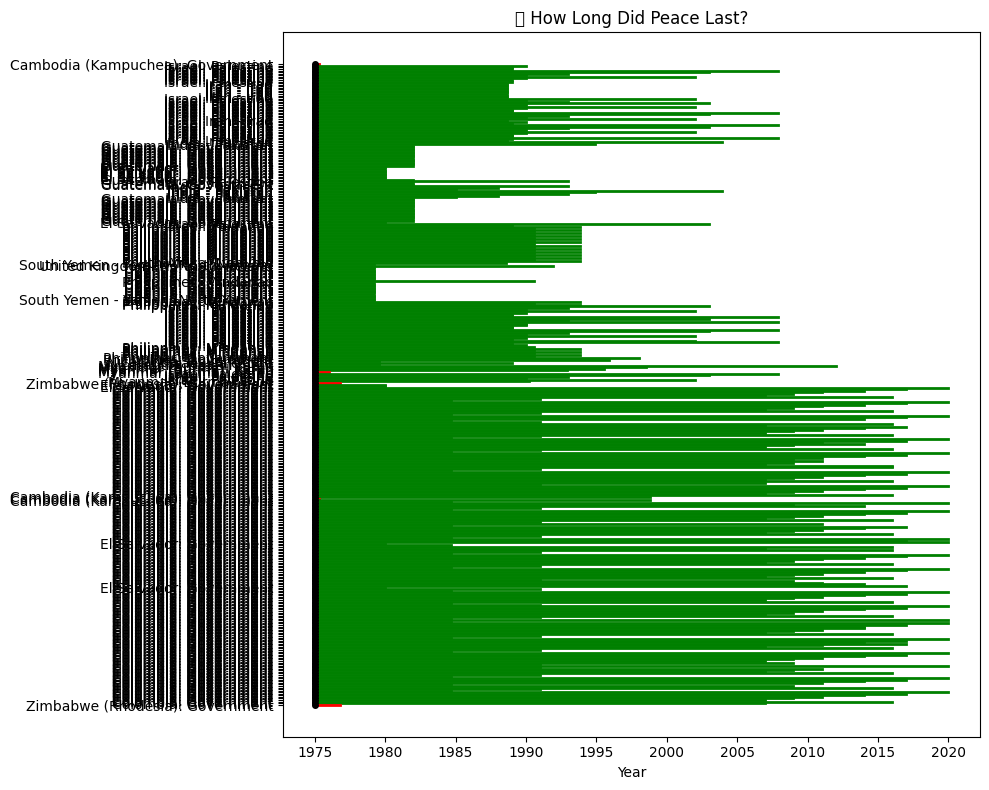

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("matched_peace_conflict_episodes.csv", parse_dates=["peace_date", "start_date", "end_date"])

# Sort by peace_date for visual clarity
df = df.sort_values("peace_date").reset_index(drop=True)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 8))

for i, row in df.iterrows():
    start = row["peace_date"]
    end = row["end_date"]
    held = not row["possible_resume"]
    color = "green" if held else "red"
    
    # Draw horizontal line
    ax.plot([start, end], [i, i], color=color, linewidth=2)
    
    # Optional: mark peace event
    ax.plot(start, i, marker='o', color='black', markersize=4)

# Format
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df["conflict_name"])
ax.invert_yaxis()  # Most recent at top
ax.set_title("⏳ How Long Did Peace Last?")
ax.set_xlabel("Year")
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# Load the matched data
df = pd.read_csv("matched_peace_conflict_episodes.csv", parse_dates=["peace_date", "end_date"])

# Function to expand rows into years
def expand_conflict_years(row):
    years = pd.date_range(row['peace_date'], row['end_date'], freq='YS').year
    return pd.DataFrame({
        'conflict_name': row['conflict_name'],
        'year': years,
        'peace_date': row['peace_date'],
        'end_date': row['end_date'],
        'resumed': row['possible_resume']
    })

# Apply to all rows
expanded = pd.concat([expand_conflict_years(row) for _, row in df.iterrows()], ignore_index=True)

# Save for Observable
expanded.to_csv("observable_conflict_lifelines.csv", index=False)
print("✅ File saved: observable_conflict_lifelines.csv")


✅ File saved: observable_conflict_lifelines.csv
